In [1]:
from __future__ import division, print_function, absolute_import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
ethnea_df = pd.read_csv('names_ethnea_genni_country.csv')
#ethnea_df

In [3]:
# First thing first, use the character feature for making the dnn model
def extract_structure(word,n_char=2):
    x_struct = []
    word_len = len(word) + n_char
    n_char-=1
    counter = 0
    for i in range(word_len):
        end = i+1
        start = (i - n_char) if (i - n_char) > 0 else 0
        if word[start:end]!='_' and word[start:end]!='':
        #if word[start:end]!='_':
            x_struct.append(word[start:end])
    return x_struct

first_name_struct = ethnea_df.First.apply(lambda x: extract_structure(x.lower(),2))
last_name_struct = ethnea_df.Last.apply(lambda x: extract_structure(x.lower(),2))                                                                

In [5]:
# make struct dictionary
struct_dict = {}
for name_struct_i in first_name_struct:
    for struct_j in name_struct_i:
        if struct_j not in struct_dict:
            struct_dict[struct_j]=0
        struct_dict[struct_j]+=1

for name_struct_i in last_name_struct:
    for struct_j in name_struct_i:
        if struct_j not in struct_dict:
            struct_dict[struct_j]=0
        struct_dict[struct_j]+=1

In [6]:
struct_dict_keys = {}
for i,key in enumerate(list(struct_dict.keys())):
    struct_dict_keys[key] = i
ethnic_series = ethnea_df['Ethnea'].str.lower()
ethnic_keys = list(np.unique(ethnic_series.values))

In [117]:
pub_series = ethnea_df.PubCountry.str.lower()
pub_keys = list(np.unique(pub_series.values))

In [9]:
# load test train data
with open('train_test_full_index.pickle', 'rb') as f:
    trainIndex,testIndex,trainY,testY = pickle.load(f)

In [ ]:
# transform the dataset into structure
def transform_structure(name_struct):
    list_structure = []
    for x in name_struct:
        try:
            list_structure.append(struct_dict_keys.index(x)+1)
        except BaseException:
            list_structure.append(0)
    #add pading 0 for structure less than num_input
    #for i in range(len(list_structure),timesteps):
    #    list_structure.append(0)
    return list_structure   
    #return [*map(lambda x:struct_dict_keys.index(x)+1, name_struct)]

In [109]:
def transform_structure(name_struct):
    list_structure = []
    for x in name_struct:
        try:
            list_structure.append(struct_dict_keys[x]+1)
        except BaseException:
            list_structure.append(0)
    #add pading 0 for structure less than num_input
    #for i in range(len(list_structure),timesteps):
    #    list_structure.append(0)
    return list_structure   
    #return [*map(lambda x:struct_dict_keys.index(x)+1, name_struct)]

#data_source = full_name_struct.apply(lambda x: transform_structure(x))

def generate_batch(first_name,last_name, i, batch_size=10000):
    len_name = len(first_name)
    start = i*batch_size
    end = start+batch_size if start+batch_size < len_name else len_name
    len_mat = end - start
    #first_name_ds_mat = np.zeros((len_mat,len(struct_dict_keys)),dtype=np.int32)
    #last_name_ds_mat = np.zeros((len_mat,50),dtype=np.int32)

    first_name_ds_mat = first_name[start:end]
    first_name_ds_mat = pad_sequences(first_name_ds_mat.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
    #first_name_ds_mat = first_name_ds_mat.reshape(first_name_ds_mat.shape[0],1,first_name_ds_mat.shape[1])
    
    last_name_ds_mat = last_name[start:end]
    last_name_ds_mat = pad_sequences(last_name_ds_mat.apply(lambda x:transform_structure(x)),maxlen=50,value=0.)
    #last_name_ds_mat = last_name_ds_mat.reshape(last_name_ds_mat.shape[0],1,last_name_ds_mat.shape[1])

    """
    for i in range(len_mat):
        x = first_name_struct.iloc[i]
        for y in x:
            first_name_ds_mat[i,struct_dict_keys[y]]+=1
        #x = last_name_struct.iloc[i]
        #for y in x:
        #    last_name_ds_mat[i,struct_dict_keys.index(y)]+=1
    """
    return first_name_ds_mat,last_name_ds_mat, range(start,end)

In [115]:
def transform_labels(x,my_keys):
    y = np.zeros(len(my_keys))
    if x in my_keys:
        y[my_keys.index(x)]=1
    return y


labels = np.array(list(map(lambda x: transform_labels(x,ethnic_keys),ethnic_series)))
#pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys),pub_series)))

In [112]:
import numpy as np
import keras
from keras.models import Sequential
from keras.models import model_from_json
from keras.models import Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import Input
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from tflearn.data_utils import to_categorical, pad_sequences



Using TensorFlow backend.


In [12]:
import math

class OverSample:
    series = None
    series_counts = {}
    series_counts_list = None
    series_dist = {}    
    series_batch_dist = {}
    series_total = 0
    series_max = 0
    series_keys = None
    
    series_counter = 0
    series_batch = 0
    series_avg_dist = 0
    
    len_keys = 0
    
    last_batch_index = 0
    
    batch_count = 0
    batch_counter = 0
    
    distribution_type = 0
    
    max_batch_dist = 0
    
    randomized = False
    
    def __init__(self,series,keys,batch,distribution_type = 0,randomized = False):
        self.series = series
        self.series_keys = keys
        self.len_keys = len(keys)
        
        self.series_counts_list = np.zeros(self.len_keys)
        
        for val in keys:
            self.series_counts[val] = 0
            self.series_dist[val] = []
        for i,val in enumerate(series):
            self.series_counts[val] +=1
            self.series_dist[val].append(i)
            self.series_total+=1      
            self.series_counts_list[keys.index(val)]+=1
        for val in keys:
            if distribution_type == 0:
                self.series_batch_dist[val] =  math.floor(series_batch / self.len_keys)
            else:
                self.series_batch_dist[val] = math.ceil(self.series_counts_list[keys.index(val)]/self.series_total * batch)
            
            if self.series_batch_dist[val] > self.max_batch_dist:
                self.max_batch_dist =  self.series_batch_dist[val]
        
        self.series_max = self.series_counts_list.max()
        self.series_batch = batch
        self.series_avg_dist = math.floor(self.series_batch / self.len_keys)
        self.batch_count = math.ceil(self.series_max / self.max_batch_dist)
        self.batch_counter = self.batch_count
        self.distribution_type = distribution_type
        self.randomized = randomized
    
    
    def reset(self):
        self.last_batch_index = 0
        self.batch_counter = self.batch_count
    
    def genNext(self):
        return_index = []
        for ethnic in self.series_keys:
            series_avg_dist = self.series_batch_dist[ethnic]
            for x in range(series_avg_dist):
                if (self.last_batch_index + x) > self.series_max:
                    # break if it's greater than max
                    break;
                my_index = (self.last_batch_index + x) % len(self.series_dist[ethnic])
                return_index.append(self.series_dist[ethnic][my_index])
        self.last_batch_index = self.last_batch_index + self.max_batch_dist
        if self.randomized:
            np.random.shuffle(return_index)
        self.batch_counter-=1
        return return_index

In [119]:
from keras.models import model_from_json
# Model definition

# last_name_model

json_file = open('model-keras-w5-bigram-sep-last-full-lstm-embedding.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

last_name_model = model_from_json(loaded_model_json)

#last_name_model.load_weights("model-keras-w5-bigram-sep-last-full-lstm-embedding-checkpoint.h5")
last_name_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


# first_name_model
json_file = open('model-keras-w5-bigram-sep-last-full-lstm-embedding.json')

loaded_model_json = json_file.read()
json_file.close()

first_name_model = model_from_json(loaded_model_json)

#first_name_model.load_weights('model-keras-w5-bigram-sep-first-full-lstm-embedding-checkpoint.h5')
first_name_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# first_name_pub_model

#first_name_pub_input = Input(shape=(len(pub_keys),),name='first_name_pub_input')
#merge_first_last = keras.layers.concatenate([fi,last_name_l])

In [120]:
last_name_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           72600     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1000)              2404000   
_________________________________________________________________
dense_4 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_5 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_6 (Dense)              (None, 26)                6526      
Total params: 3,108,876
Trainable params: 3,108,876
Non-trainable params: 0
_________________________________________________________________


In [121]:
# change the name label for conflict issue
first_name_model.layers[0].name = "embedding_first_name"
first_name_model.layers[1].name = "bidirectional_first_name"
first_name_model.layers[2].name = "hidden_first_name_1"
first_name_model.layers[3].name = "hidden_first_name_2"
first_name_model.layers[4].name = "first_name_output"


last_name_model.layers[0].name = "embedding_last_name"
last_name_model.layers[1].name = "bidirectional_last_name"
last_name_model.layers[2].name = "hidden_last_name_1"
last_name_model.layers[3].name = "hidden_last_name_2"
last_name_model.layers[4].name = "last_name_output"

first_name_model.get_layer('embedding_2_input').name='embedding_first_name_input'
last_name_model.get_layer('embedding_2_input').name='embedding_last_name_input'


last_name_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_last_name (Embeddi (None, 50, 100)           72600     
_________________________________________________________________
bidirectional_last_name (Bid (None, 1000)              2404000   
_________________________________________________________________
hidden_last_name_1 (Dense)   (None, 500)               500500    
_________________________________________________________________
hidden_last_name_2 (Dense)   (None, 250)               125250    
_________________________________________________________________
last_name_output (Dense)     (None, 26)                6526      
Total params: 3,108,876
Trainable params: 3,108,876
Non-trainable params: 0
_________________________________________________________________


In [122]:
# integration



first_name_input = first_name_model.get_layer('embedding_first_name').input
#first_name_input.name = 'embedding_first_name_input'
#first_name_input = Input(shape=(None,50),name='first_name_input',dtype='float32')
first_name_output = first_name_model.get_layer('first_name_output').output

last_name_input = last_name_model.get_layer('embedding_last_name').input
#last_name_input.name = 'embedding_last_name_input'
#last_name_input = Input(shape=(None,50),name='last_name_input',dtype='float32')
last_name_output = last_name_model.get_layer('last_name_output').output

pub_input = Input(shape=(len(pub_keys),),name='pub_input')

# first_name_pub
merge_first_name_pub = keras.layers.concatenate([first_name_output,pub_input],name='merge_first_name_pub_1')
merge_first_name_pub_hidden = Dense(100, activation='relu',name='hidden_first_name_pub_1')(merge_first_name_pub)
first_name_pub_output = Dense(len(ethnic_keys),activation='softmax',name='first_name_pub_output')(merge_first_name_pub_hidden)

# last_name_pub
merge_last_name_pub = keras.layers.concatenate([last_name_output,pub_input],name='merge_last_name_pub_1')
merge_last_name_pub_hidden = Dense(100, activation='relu',name='hidden_last_name_pub_1')(merge_last_name_pub)
last_name_pub_output = Dense(len(ethnic_keys),activation='softmax',name='last_name_pub_output')(merge_last_name_pub_hidden)

# first_last_name
merge_first_last = keras.layers.concatenate([first_name_output,last_name_output],name='merge_first_last_name_1')
merge_first_last_hidden = Dense(100, activation='relu',name='hidden_first_last_name_1')(merge_first_last)
first_last_name_output = Dense(len(ethnic_keys),activation='softmax',name='first_last_name_output')(merge_first_last_hidden)

# first_last_name_pub
merge_first_last_name_pub = keras.layers.concatenate([first_name_output,last_name_output,pub_input],name='merge_first_last_name_pub')
merge_first_last_name_pub_hidden = Dense(100, activation='relu',name='hidden_first_last_name_pub_1')(merge_first_last_name_pub)
first_last_name_pub_output = Dense(len(ethnic_keys),activation='softmax',name='first_last_name_pub_output')(merge_first_last_name_pub_hidden)


first_last_name_model = Model(inputs=[first_name_input,last_name_input,pub_input], outputs=[first_name_output,last_name_output,first_name_pub_output,last_name_pub_output,first_last_name_output,first_last_name_pub_output])
first_last_name_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [123]:
first_last_name_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_first_name_input (Inpu (None, 50)            0                                            
____________________________________________________________________________________________________
embedding_last_name_input (Input (None, 50)            0                                            
____________________________________________________________________________________________________
embedding_first_name (Embedding) (None, 50, 100)       72600       embedding_first_name_input[0][0] 
____________________________________________________________________________________________________
embedding_last_name (Embedding)  (None, 50, 100)       72600       embedding_last_name_input[0][0]  
___________________________________________________________________________________________

In [18]:
mini_batch_size = 50000
sample = OverSample(ethnic_series[trainIndex],ethnic_keys,mini_batch_size,1)

In [19]:
sample.batch_counter = 22+1
sample.last_batch_index = (sample.batch_count - sample.batch_counter) * sample.max_batch_dist

In [19]:
sample.last_batch_index

0

In [128]:
first_trainX = first_name_struct[trainIndex]
first_testX = first_name_struct[testIndex]
last_trainX = last_name_struct[trainIndex]
last_testX = last_name_struct[testIndex]
trainY = labels[trainIndex]
testY = labels[testIndex]

mini_batch_size = 50000
len_mini_batch = round(len(trainY)/mini_batch_size)
batch_size = 500

for x in range(1):
    #sample.reset()
    #nextList = sample.genNext()
    while(len(nextList)>0):
        #y_first_trainX, y_last_trainX, batch_range =  generate_batch(first_trainX,last_trainX,y,mini_batch_size)        
        print("batch {}".format(sample.batch_counter))
        # get the first input value
        #print('Compute first name output')
        first_name_ds_mat = pad_sequences(first_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #first_name_output = first_name_model.predict([first_name_ds_mat],batch_size=batch_size)
        #with("first-name-output-1-{}".format(sample.batch_counter),"rb") as file:
        #    pickle.dumps(first_name_output,file)
        
        #print('Compute last name output')                
        
        last_name_ds_mat = pad_sequences(last_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #last_name_output = last_name_model.predict([first_name_ds_mat],batch_size=batch_size)
        #with("last-name-output-1-{}".format(sample.batch_counter),"rb") as file:
        #    pickle.dumps(last_name_output,file)

        pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys),pub_series[trainIndex].iloc[nextList])))
        
        first_last_name_model.fit([first_name_ds_mat, last_name_ds_mat, pub_country],[trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList]],epochs=1,batch_size=batch_size)
                
        nextList = sample.genNext()
        first_last_name_model.save_weights('model-keras-w5-bigram-integration-full-lstm-embedding-checkpoint.h5')    
        #first_test_ds_mat = pad_sequences(first_testX.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #first_test_ds_mat = first_test_ds_mat.reshape(first_test_ds_mat.shape[0],1,first_test_ds_mat.shape[1])
        #scores = first_name_model.evaluate([first_test_ds_mat],testY,verbose=0)
        #print("Accuracy: %.2f%%" %(scores[1]*100))

batch 2
Epoch 1/1
50014/50014 [==============================] - 1725s - loss: 2.2113 - first_name_output_loss: 0.6192 - last_name_output_loss: 0.4826 - first_name_pub_output_loss: 0.4194 - last_name_pub_output_loss: 0.3137 - first_last_name_output_loss: 0.2104 - first_last_name_pub_output_loss: 0.1659 - first_name_output_acc: 0.8180 - last_name_output_acc: 0.8551 - first_name_pub_output_acc: 0.8907 - last_name_pub_output_acc: 0.9077 - first_last_name_output_acc: 0.9363 - first_last_name_pub_output_acc: 0.9498  
batch 1
Epoch 1/1
50014/50014 [==============================] - 1643s - loss: 2.2376 - first_name_output_loss: 0.6223 - last_name_output_loss: 0.4940 - first_name_pub_output_loss: 0.4139 - last_name_pub_output_loss: 0.3210 - first_last_name_output_loss: 0.2175 - first_last_name_pub_output_loss: 0.1688 - first_name_output_acc: 0.8190 - last_name_output_acc: 0.8519 - first_name_pub_output_acc: 0.8931 - last_name_pub_output_acc: 0.9054 - first_last_name_output_acc: 0.9352 - first

In [124]:
#json_file = open('model-keras-w5-big', 'r')
#loaded_model_json = json_file.read()
#json_file.close()

first_last_name_model.load_weights('model-keras-w5-bigram-integration-full-lstm-embedding-checkpoint.h5')

In [22]:
#first_name_model.load_weights('model-keras-w5-bigram-sep-first-full-lstm-embeddingc-3.h5')

In [22]:
first_trainX = first_name_struct[trainIndex]
first_testX = first_name_struct[testIndex]
last_trainX = last_name_struct[trainIndex]
last_testX = last_name_struct[testIndex]
trainY = labels[trainIndex]
testY = labels[testIndex]

mini_batch_size = 50000
len_mini_batch = round(len(trainY)/mini_batch_size)
batch_size = 500

for x in range(1):
    sample.reset()
    nextList = sample.genNext()
    while(len(nextList)>0):
        #y_first_trainX, y_last_trainX, batch_range =  generate_batch(first_trainX,last_trainX,y,mini_batch_size)        
        print("batch {}".format(sample.batch_counter))
        # get the first input value
        #print('Compute first name output')
        first_name_ds_mat = pad_sequences(first_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #first_name_output = first_name_model.predict([first_name_ds_mat],batch_size=batch_size)
        #with("first-name-output-1-{}".format(sample.batch_counter),"rb") as file:
        #    pickle.dumps(first_name_output,file)
        
        #print('Compute last name output')                
        
        last_name_ds_mat = pad_sequences(last_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #last_name_output = last_name_model.predict([first_name_ds_mat],batch_size=batch_size)
        #with("last-name-output-1-{}".format(sample.batch_counter),"rb") as file:
        #    pickle.dumps(last_name_output,file)

        pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys),pub_series[trainIndex].iloc[nextList])))
        
        first_last_name_model.fit([first_name_ds_mat, last_name_ds_mat, pub_country],[trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList]],epochs=1,batch_size=batch_size)
                
        nextList = sample.genNext()
        first_last_name_model.save_weights('model-keras-w5-bigram-integration-full-lstm-embedding-checkpoint.h5')    
        #first_test_ds_mat = pad_sequences(first_testX.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #first_test_ds_mat = first_test_ds_mat.reshape(first_test_ds_mat.shape[0],1,first_test_ds_mat.shape[1])
        #scores = first_name_model.evaluate([first_test_ds_mat],testY,verbose=0)
        #print("Accuracy: %.2f%%" %(scores[1]*100))

batch 22
Epoch 1/1
50014/50014 [==============================] - 1813s - loss: 1.6022 - first_name_output_loss: 0.5214 - last_name_output_loss: 0.3379 - first_name_pub_output_loss: 0.3596 - last_name_pub_output_loss: 0.2096 - first_last_name_output_loss: 0.0954 - first_last_name_pub_output_loss: 0.0783 - first_name_output_acc: 0.8420 - last_name_output_acc: 0.8996 - first_name_pub_output_acc: 0.9062 - last_name_pub_output_acc: 0.9389 - first_last_name_output_acc: 0.9714 - first_last_name_pub_output_acc: 0.9766  
batch 21
Epoch 1/1
50014/50014 [==============================] - 1800s - loss: 1.9496 - first_name_output_loss: 0.5634 - last_name_output_loss: 0.4343 - first_name_pub_output_loss: 0.3777 - last_name_pub_output_loss: 0.2793 - first_last_name_output_loss: 0.1631 - first_last_name_pub_output_loss: 0.1318 - first_name_output_acc: 0.8295 - last_name_output_acc: 0.8699 - first_name_pub_output_acc: 0.9000 - last_name_pub_output_acc: 0.9168 - first_last_name_output_acc: 0.9500 - fir

In [23]:
first_trainX = first_name_struct[trainIndex]
first_testX = first_name_struct[testIndex]
last_trainX = last_name_struct[trainIndex]
last_testX = last_name_struct[testIndex]
trainY = labels[trainIndex]
testY = labels[testIndex]

mini_batch_size = 50000
len_mini_batch = round(len(trainY)/mini_batch_size)
batch_size = 500

for x in range(1):
    sample.reset()
    nextList = sample.genNext()
    while(len(nextList)>0):
        #y_first_trainX, y_last_trainX, batch_range =  generate_batch(first_trainX,last_trainX,y,mini_batch_size)        
        print("batch {}".format(sample.batch_counter))
        # get the first input value
        #print('Compute first name output')
        first_name_ds_mat = pad_sequences(first_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #first_name_output = first_name_model.predict([first_name_ds_mat],batch_size=batch_size)
        #with("first-name-output-1-{}".format(sample.batch_counter),"rb") as file:
        #    pickle.dumps(first_name_output,file)
        
        #print('Compute last name output')                
        
        last_name_ds_mat = pad_sequences(last_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #last_name_output = last_name_model.predict([first_name_ds_mat],batch_size=batch_size)
        #with("last-name-output-1-{}".format(sample.batch_counter),"rb") as file:
        #    pickle.dumps(last_name_output,file)

        pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys),pub_series[trainIndex].iloc[nextList])))
        
        first_last_name_model.fit([first_name_ds_mat, last_name_ds_mat, pub_country],[trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList]],epochs=1,batch_size=batch_size)
                
        nextList = sample.genNext()
        first_last_name_model.save_weights('model-keras-w5-bigram-integration-full-lstm-embedding-checkpoint.h5')    
        #first_test_ds_mat = pad_sequences(first_testX.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #first_test_ds_mat = first_test_ds_mat.reshape(first_test_ds_mat.shape[0],1,first_test_ds_mat.shape[1])
        #scores = first_name_model.evaluate([first_test_ds_mat],testY,verbose=0)
        #print("Accuracy: %.2f%%" %(scores[1]*100))

batch 70
Epoch 1/1
50014/50014 [==============================] - 2836s - loss: 1.8205 - first_name_output_loss: 0.5384 - last_name_output_loss: 0.4097 - first_name_pub_output_loss: 0.3623 - last_name_pub_output_loss: 0.2602 - first_last_name_output_loss: 0.1374 - first_last_name_pub_output_loss: 0.1125 - first_name_output_acc: 0.8372 - last_name_output_acc: 0.8779 - first_name_pub_output_acc: 0.9036 - last_name_pub_output_acc: 0.9210 - first_last_name_output_acc: 0.9579 - first_last_name_pub_output_acc: 0.9647  
batch 69
Epoch 1/1
50014/50014 [==============================] - 2817s - loss: 1.8518 - first_name_output_loss: 0.5511 - last_name_output_loss: 0.4063 - first_name_pub_output_loss: 0.3760 - last_name_pub_output_loss: 0.2589 - first_last_name_output_loss: 0.1424 - first_last_name_pub_output_loss: 0.1170 - first_name_output_acc: 0.8339 - last_name_output_acc: 0.8784 - first_name_pub_output_acc: 0.9016 - last_name_pub_output_acc: 0.9231 - first_last_name_output_acc: 0.9575 - fir

50014/50014 [==============================] - 2763s - loss: 1.7455 - first_name_output_loss: 0.5292 - last_name_output_loss: 0.3906 - first_name_pub_output_loss: 0.3567 - last_name_pub_output_loss: 0.2463 - first_last_name_output_loss: 0.1226 - first_last_name_pub_output_loss: 0.1001 - first_name_output_acc: 0.8394 - last_name_output_acc: 0.8833 - first_name_pub_output_acc: 0.9056 - last_name_pub_output_acc: 0.9249 - first_last_name_output_acc: 0.9617 - first_last_name_pub_output_acc: 0.9682  
batch 39
Epoch 1/1
50014/50014 [==============================] - 2673s - loss: 1.7596 - first_name_output_loss: 0.5422 - last_name_output_loss: 0.3836 - first_name_pub_output_loss: 0.3655 - last_name_pub_output_loss: 0.2435 - first_last_name_output_loss: 0.1229 - first_last_name_pub_output_loss: 0.1021 - first_name_output_acc: 0.8354 - last_name_output_acc: 0.8846 - first_name_pub_output_acc: 0.9043 - last_name_pub_output_acc: 0.9269 - first_last_name_output_acc: 0.9616 - first_last_name_pub_ou

50014/50014 [==============================] - 2690s - loss: 1.6586 - first_name_output_loss: 0.5172 - last_name_output_loss: 0.3689 - first_name_pub_output_loss: 0.3492 - last_name_pub_output_loss: 0.2337 - first_last_name_output_loss: 0.1032 - first_last_name_pub_output_loss: 0.0864 - first_name_output_acc: 0.8412 - last_name_output_acc: 0.8876 - first_name_pub_output_acc: 0.9067 - last_name_pub_output_acc: 0.9298 - first_last_name_output_acc: 0.9684 - first_last_name_pub_output_acc: 0.9729  
batch 9
Epoch 1/1
50014/50014 [==============================] - 2686s - loss: 1.6419 - first_name_output_loss: 0.5120 - last_name_output_loss: 0.3615 - first_name_pub_output_loss: 0.3527 - last_name_pub_output_loss: 0.2281 - first_last_name_output_loss: 0.1011 - first_last_name_pub_output_loss: 0.0864 - first_name_output_acc: 0.8448 - last_name_output_acc: 0.8897 - first_name_pub_output_acc: 0.9067 - last_name_pub_output_acc: 0.9293 - first_last_name_output_acc: 0.9684 - first_last_name_pub_out

In [26]:
first_trainX = first_name_struct[trainIndex]
first_testX = first_name_struct[testIndex]
last_trainX = last_name_struct[trainIndex]
last_testX = last_name_struct[testIndex]
trainY = labels[trainIndex]
testY = labels[testIndex]

mini_batch_size = 50000
len_mini_batch = round(len(trainY)/mini_batch_size)
batch_size = 500

for x in range(1):
    sample.reset()
    nextList = sample.genNext()
    while(len(nextList)>0):
        #y_first_trainX, y_last_trainX, batch_range =  generate_batch(first_trainX,last_trainX,y,mini_batch_size)        
        print("batch {}".format(sample.batch_counter))
        # get the first input value
        #print('Compute first name output')
        first_name_ds_mat = pad_sequences(first_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #first_name_output = first_name_model.predict([first_name_ds_mat],batch_size=batch_size)
        #with("first-name-output-1-{}".format(sample.batch_counter),"rb") as file:
        #    pickle.dumps(first_name_output,file)
        
        #print('Compute last name output')                
        
        last_name_ds_mat = pad_sequences(last_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #last_name_output = last_name_model.predict([first_name_ds_mat],batch_size=batch_size)
        #with("last-name-output-1-{}".format(sample.batch_counter),"rb") as file:
        #    pickle.dumps(last_name_output,file)

        pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys),pub_series[trainIndex].iloc[nextList])))
        
        first_last_name_model.fit([first_name_ds_mat, last_name_ds_mat, pub_country],[trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList]],epochs=1,batch_size=batch_size)
                
        nextList = sample.genNext()
        first_last_name_model.save_weights('model-keras-w5-bigram-integration-full-lstm-embeddingc-checkpoint.h5')    
        #first_test_ds_mat = pad_sequences(first_testX.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #first_test_ds_mat = first_test_ds_mat.reshape(first_test_ds_mat.shape[0],1,first_test_ds_mat.shape[1])
        #scores = first_name_model.evaluate([first_test_ds_mat],testY,verbose=0)
        #print("Accuracy: %.2f%%" %(scores[1]*100))

batch 70
Epoch 1/1
50014/50014 [==============================] - 1629s - loss: 1.5575 - first_name_output_loss: 0.4595 - last_name_output_loss: 0.3656 - first_name_pub_output_loss: 0.3266 - last_name_pub_output_loss: 0.2303 - first_last_name_output_loss: 0.0948 - first_last_name_pub_output_loss: 0.0807 - first_name_output_acc: 0.8537 - last_name_output_acc: 0.8886 - first_name_pub_output_acc: 0.9118 - last_name_pub_output_acc: 0.9299 - first_last_name_output_acc: 0.9704 - first_last_name_pub_output_acc: 0.9740  
batch 69
Epoch 1/1
  500/50014 [..............................] - ETA: 1567s - loss: 1.6322 - first_name_output_loss: 0.5143 - last_name_output_loss: 0.3526 - first_name_pub_output_loss: 0.3269 - last_name_pub_output_loss: 0.2561 - first_last_name_output_loss: 0.0972 - first_last_name_pub_output_loss: 0.0850 - first_name_output_acc: 0.8180 - last_name_output_acc: 0.9000 - first_name_pub_output_acc: 0.9000 - last_name_pub_output_acc: 0.9240 - first_last_name_output_acc: 0.9720 

KeyboardInterrupt: 

In [139]:
index = ["first_name","last_name","first_name_pub","last_name_pub","first_last_name","first_last_name_pub","first_pub_last_name_join","last_pub_first_name_join"]

def trans_name(name):
    name = name.lower()
    # transform space into underscore
    name = '_'+name.replace(' ','_')+'_'
    #transform the name into sequence structure
    ext_name = extract_structure(name)
    trans_name = transform_structure(ext_name)
    """
    name_ds_mat = np.zeros((1,len(struct_dict_keys)),dtype=np.int32)
    for i,x in enumerate(trans_name):
        name_ds_mat[0,x-1]+=1
    """
    trans_name = pad_sequences([trans_name], maxlen=50,value=0.)
    #trans_name = trans_name.reshape(trans_name.shape[0],1,trans_name.shape[1])
    return trans_name

def predict_ethnicity(fname="",lname="",pub=""):
    # lower case the name
    fnamex = trans_name(fname)
    lnamex = trans_name(lname)
    pub_country = transform_labels(pub.lower(),pub_keys)    
    preds = first_last_name_model.predict([np.array(fnamex),np.array(lnamex),pub_country.reshape(1,275)])
    return_item = {}
    p_fname  = {}
    p_lname = {}
    p_fname_pub = {}
    p_lname_pub = {}
    p_type = 0
    if fname!="" and lname=="":
        if np.sum(pub_country) == 0 :
            p_type = 1
        else:
            p_type = 2
    elif fname=="" and lname!="":
        if np.sum(pub_country) == 0 :
            p_type = 3
        else:
            p_type = 4
    elif np.sum(pub_country) == 0:
        p_type = 5

    outputs = {}
    outputs[0] = ["first_last_name","first_last_name_join","first_last_name_pub","first_name","first_name_pub","last_name","last_name_pub","first_pub_last_name_join","last_pub_first_name_join"]
    outputs[1] = ["first_name"]
    outputs[2] = ["first_name","first_name_pub"]
    outputs[3] = ["last_name"]
    outputs[4] = ["last_name","last_name_pub"]
    outputs[5] = ["first_last_name","first_last_name_join","first_name","last_name"]
        
    for i,pred in enumerate(preds):
        classes = []
        for x in np.argsort(pred[0])[::-1]:
            classes.append((ethnic_keys[x],pred[0][x]))
            if index[i] == "first_name":
                p_fname[ethnic_keys[x]] = pred[0][x]
            if index[i] == "last_name":
                p_lname[ethnic_keys[x]] = pred[0][x]
            if index[i] == "first_name_pub":
                p_fname_pub[ethnic_keys[x]] = pred[0][x]
            if index[i] == "last_name_pub":
                p_lname_pub[ethnic_keys[x]] = pred[0][x]

        return_item[index[i]] = classes
        
    # first name last name join prob
    join_result = {}
    join_result_pub = {}
    join_result_first_pub_last = {}
    join_result_last_pub_first = {}
    total = 0
    total_pub = 0
    total_first_pub_last = 0
    total_last_pub_first = 0
    
    for eth in ethnic_keys:
        join = p_fname[eth] * p_lname[eth]
        join_pub = p_fname_pub[eth] * p_lname_pub[eth]
        join_first_pub_last = p_fname_pub[eth] * p_lname[eth]
        join_last_pub_first = p_fname[eth] * p_lname_pub[eth]
        join_result[eth] = join
        join_result_pub[eth] = join_pub
        join_result_first_pub_last[eth] = join_first_pub_last
        join_result_last_pub_first[eth] = join_last_pub_first
        total += join
        total_pub += join_pub
        total_first_pub_last += join_first_pub_last
        total_last_pub_first += join_last_pub_first
        
    # normalize
    join_result_list = []
    join_pub_result_list = []
    join_first_pub_last_result_list = []
    join_last_pub_first_result_list = []
    for eth in ethnic_keys:
        join_result_list.append((eth,join_result[eth] / total))
        join_pub_result_list.append((eth,join_result_pub[eth]/total_pub))
        join_first_pub_last_result_list.append((eth,join_result_first_pub_last[eth]/total_first_pub_last))
        join_last_pub_first_result_list.append((eth,join_result_last_pub_first[eth]/total_last_pub_first))
    
    join_result_list = sorted(join_result_list, key=lambda x:x[1])[::-1]
    join_pub_result_list = sorted(join_pub_result_list, key=lambda x:x[1])[::-1]
    join_first_pub_last_result_list = sorted(join_first_pub_last_result_list, key=lambda x:x[1])[::-1]
    join_last_pub_first_result_list = sorted(join_last_pub_first_result_list, key=lambda x:x[1])[::-1]
    
    return_item["first_last_name_join"] = join_result_list
    return_item["first_last_name_pub_join"] = join_pub_result_list
    return_item["first_pub_last_name_join"] = join_first_pub_last_result_list
    return_item["last_pub_first_name_join"] = join_last_pub_first_result_list
    
    rendered_return = {}
    # render the output
    for key in outputs[p_type]:
        rendered_return[key] = return_item[key]
    
    return rendered_return

In [142]:
test = predict_ethnicity('nikolaus','parulian','')
pd.DataFrame(test)
#trans_name('Nikolaus')
#x = [(1,2,3),(2,3,4),(2,1,3)]
#sorted(x,key=lambda x: x[1])[::-1]

,first_last_name,first_last_name_join,first_name,last_name
0,"(german, 0.945421)","(german, 0.85104871381)","(german, 0.964221)","(slav, 0.344384)"
1,"(slav, 0.0250729)","(english, 0.0715497060146)","(english, 0.00976284)","(french, 0.221008)"
2,"(french, 0.0162305)","(french, 0.0693546996449)","(french, 0.00836458)","(english, 0.195348)"
3,"(dutch, 0.00423231)","(hispanic, 0.00428107090184)","(greek, 0.00734365)","(hispanic, 0.112997)"
4,"(english, 0.00342874)","(greek, 0.00182720199966)","(nordic, 0.00600397)","(italian, 0.0285415)"
5,"(hungarian, 0.00268874)","(slav, 0.00142960792679)","(dutch, 0.00240067)","(indian, 0.0266218)"
6,"(nordic, 0.000865932)","(dutch, 0.00038423726786)","(hispanic, 0.00100987)","(german, 0.0235263)"
7,"(hispanic, 0.000861279)","(indian, 5.99980086146e-05)","(african, 0.000450148)","(romanian, 0.0114339)"
8,"(greek, 0.000388489)","(italian, 2.72797465482e-05)","(chinese, 0.000128108)","(arab, 0.010058)"
9,"(israeli, 0.000221074)","(nordic, 1.50789607904e-05)","(slav, 0.00011065)","(greek, 0.00663209)"


In [ ]:
# store the predictions probabilities, predictions and labels
def evaluate_probs(firstX, lastX, pub_series, testY, testIndex, mini_batch_size=20000):
    test_class = []
    pred_class = [[],[],[],[],[],[]]
    pred_prob = [[],[],[],[],[],[]]
    
    test_len = len(testY)
    len_mini_batch = round(test_len/mini_batch_size)+1
    print(len_mini_batch)
    for i in range(len_mini_batch):
        print(i)
        y_first_trainX,y_last_trainX,batch_range = generate_batch(firstX,lastX,i,mini_batch_size)
        pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys), pub_series[testIndex].iloc[batch_range])))        
        preds = first_last_name_model.predict([y_first_trainX,y_last_trainX,pub_country],batch_size=1000)
        #print(len(preds))
        #print(len(preds[0]))
        for i,pred in enumerate(preds):
            pred_class[i].extend([np.argsort(x)[::-1][0] for x in pred])
            pred_prob[i].extend([x[np.argsort(x)[::-1][0]] for x in pred])
        #print(len(pred_class))
        #print(len(pred_class[0]))
    return pred_class,pred_prob
    #scores = model.evaluate([first_testX, last_testX],testY,verbose=0)
    

In [28]:
pred_class, pred_prob = evaluate_probs(first_testX,last_testX, pub_series, testY, testIndex)

45
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


In [7]:
with open('evaluation-2.pickle','rb') as file:
    pred_class,pred_prob = pickle.load(file)

In [69]:
# table of precision and recall for each ethnicity
#from sklearn.metrics import precision_score
#precision_score(,testY,average='weighted')
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(testY,pred_class[5])

In [88]:
precision = cnf_matrix.astype('float') / cnf_matrix.sum(axis=0)[:, np.newaxis]
recall = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

/Volumes/HD-500GB/Users/nikolausn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [93]:
precision[3]
#cnf_matrix[3][3]
cnf_matrix.sum(axis=0)[:, np.newaxis]

array([[  3611],
       [ 27238],
       [   781],
       [     1],
       [ 83778],
       [ 18121],
       [293401],
       [ 40743],
       [ 72814],
       [  7679],
       [ 84913],
       [  3230],
       [ 31040],
       [   192],
       [  6426],
       [ 37689],
       [ 87248],
       [ 15041],
       [     9],
       [ 26864],
       [     0],
       [  1538],
       [ 29808],
       [  3628],
       [ 10486],
       [   538]])

In [143]:
def conf_table(pred_class,testY):
    cnf_matrix = confusion_matrix(testY,pred)
    precision = cnf_matrix.astype('float') / cnf_matrix.sum(axis=0)[np.newaxis,:]
    recall = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    prec_df = pd.DataFrame(index=ethnic_keys)
    prec_df["precision"] = None
    prec_df["recall"] = None
    prec_list = []
    recall_list = []
    second_prec = [[],[],[]]
    second_recall = [[],[],[]]
    for i,key in enumerate(ethnic_keys):
        #df_row = {'precision': precision[i,i],'recall':recall[i,i]}
        #prec_df.iloc[i].map(df_row)
        prec_list.append(precision[i,i])    
        recall_list.append(recall[i,i])
        for j in range(3):
            t =  np.argsort(precision[:,i])[::-1][j]        
            et = np.array(ethnic_keys)[t]
            etval = precision[t,i]
            second_prec[j].append((et,etval))
            t =  np.argsort(recall[i])[::-1][j]        
            et = np.array(ethnic_keys)[t]
            etval = recall[i,t]
            second_recall[j].append((et,etval))
        #prec_df.iloc[i,'precision'] = precision[i,i]
    prec_df['precision'] = prec_list
    prec_df['recall'] = recall_list
    for i, prec_tmp in enumerate(second_prec):
        prec_df["precision-{}".format(i+1)] = prec_tmp
    for i, rec_tmp in enumerate(second_recall):
        prec_df["recall-{}".format(i+1)] = rec_tmp
    return prec_df

In [144]:
from IPython.display import display
for i,pred in enumerate(pred_class):
    print("Precision {}".format(index[i]))
    display(conf_table(pred,testY))

Precision first_name


/Volumes/HD-500GB/Users/nikolausn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


,precision,recall,precision-1,precision-2,precision-3,recall-1,recall-2,recall-3
african,0.705696,0.303898,"(african, 0.705696202532)","(hispanic, 0.0455696202532)","(arab, 0.0417721518987)","(english, 0.356500408831)","(african, 0.30389751976)","(hispanic, 0.0615971654402)"
arab,0.866781,0.890247,"(arab, 0.866781059472)","(turkish, 0.0237669307437)","(indian, 0.0223065970574)","(arab, 0.890247103378)","(indian, 0.0241103903408)","(english, 0.0194607971802)"
baltic,0.718062,0.656376,"(baltic, 0.718061674009)","(hispanic, 0.0660792951542)","(nordic, 0.0396475770925)","(baltic, 0.656375838926)","(hispanic, 0.106040268456)","(slav, 0.0818791946309)"
caribbean,NaN,0.000000,"(vietnamese, nan)","(turkish, nan)","(arab, nan)","(english, 0.428571428571)","(indian, 0.142857142857)","(arab, 0.142857142857)"
chinese,0.957976,0.929525,"(chinese, 0.95797579758)","(korean, 0.0114289206698)","(japanese, 0.00739518396284)","(chinese, 0.929525345731)","(english, 0.0397798704841)","(korean, 0.00719927888607)"
dutch,0.718686,0.452193,"(dutch, 0.718686022706)","(german, 0.0781686208822)","(nordic, 0.0624418388237)","(dutch, 0.452192751332)","(english, 0.292171672815)","(german, 0.0868317817202)"
english,0.796715,0.956823,"(english, 0.79671505274)","(german, 0.0607651804818)","(french, 0.0353062625074)","(english, 0.956822872657)","(hispanic, 0.0104583673865)","(german, 0.0088930753141)"
french,0.810849,0.628920,"(french, 0.810848759241)","(english, 0.0653046019829)","(dutch, 0.0335262765775)","(french, 0.628920054231)","(english, 0.272131220412)","(german, 0.0330940368502)"
german,0.786794,0.587248,"(german, 0.786793747334)","(nordic, 0.0496764264125)","(english, 0.0476181646239)","(german, 0.58724776483)","(english, 0.291651673264)","(hispanic, 0.0310847842334)"
greek,0.903813,0.694168,"(greek, 0.903813415049)","(english, 0.0223016683691)","(slav, 0.0205992509363)","(greek, 0.694168410042)","(english, 0.150496861925)","(hispanic, 0.0768828451883)"


Precision last_name


,precision,recall,precision-1,precision-2,precision-3,recall-1,recall-2,recall-3
african,0.608292,0.535841,"(african, 0.608292079208)","(french, 0.0751856435644)","(english, 0.0491955445545)","(african, 0.535840828564)","(english, 0.100027255383)","(indian, 0.0512401199237)"
arab,0.806509,0.894784,"(arab, 0.806509395701)","(english, 0.035385967284)","(french, 0.0335609030688)","(arab, 0.894784206382)","(indian, 0.0225355281413)","(english, 0.0217480970415)"
baltic,0.692213,0.751678,"(baltic, 0.692212608158)","(english, 0.113720642769)","(hispanic, 0.0432632880099)","(baltic, 0.751677852349)","(english, 0.0671140939597)","(greek, 0.061744966443)"
caribbean,NaN,0.000000,"(vietnamese, nan)","(turkish, nan)","(arab, nan)","(english, 0.619047619048)","(indian, 0.142857142857)","(slav, 0.0952380952381)"
chinese,0.941080,0.962142,"(chinese, 0.941079569843)","(english, 0.0342339416016)","(korean, 0.0164963283489)","(chinese, 0.962141518609)","(korean, 0.0213487677017)","(english, 0.00673672225253)"
dutch,0.772140,0.786697,"(dutch, 0.772139532211)","(french, 0.0586747888052)","(german, 0.051318889719)","(dutch, 0.786697113414)","(german, 0.0774050002928)","(english, 0.0622401779964)"
english,0.903051,0.890461,"(english, 0.903051226039)","(german, 0.0235093313853)","(french, 0.0204925229509)","(english, 0.890460722251)","(german, 0.0414456095635)","(chinese, 0.010219417933)"
french,0.790972,0.620763,"(french, 0.790971651893)","(english, 0.0625584095608)","(hispanic, 0.0389397071734)","(french, 0.620763229836)","(english, 0.129686840175)","(german, 0.0644989220545)"
german,0.734949,0.821795,"(german, 0.734949004852)","(english, 0.148133478562)","(french, 0.0359193979602)","(german, 0.82179533313)","(english, 0.0926453898746)","(slav, 0.0199850527306)"
greek,0.806301,0.883368,"(greek, 0.806301467956)","(english, 0.0634920634921)","(hispanic, 0.0285236901778)","(greek, 0.883368200837)","(english, 0.0203974895397)","(hispanic, 0.0202667364017)"


Precision first_name_pub


,precision,recall,precision-1,precision-2,precision-3,recall-1,recall-2,recall-3
african,0.694718,0.537749,"(african, 0.694718309859)","(english, 0.102112676056)","(french, 0.0362676056338)","(african, 0.537748705369)","(english, 0.254565276642)","(french, 0.0318887980376)"
arab,0.910091,0.924594,"(arab, 0.91009079501)","(indian, 0.017457739721)","(french, 0.0170886543146)","(arab, 0.924594098016)","(indian, 0.0230229854888)","(english, 0.0155611384004)"
baltic,0.817380,0.871141,"(baltic, 0.817380352645)","(slav, 0.0377833753149)","(german, 0.0302267002519)","(baltic, 0.871140939597)","(nordic, 0.0295302013423)","(slav, 0.0241610738255)"
caribbean,0.000000,0.000000,"(indian, 0.5)","(arab, 0.5)","(turkish, 0.0)","(english, 0.52380952381)","(indian, 0.190476190476)","(arab, 0.0952380952381)"
chinese,0.973278,0.945181,"(chinese, 0.973277967758)","(english, 0.00719345383488)","(korean, 0.00545920859795)","(chinese, 0.945181108713)","(english, 0.0329957065256)","(korean, 0.00851578622767)"
dutch,0.814333,0.747819,"(dutch, 0.814333078296)","(german, 0.0492221372099)","(english, 0.0473731191023)","(dutch, 0.747818958955)","(english, 0.123660635869)","(french, 0.0441477838281)"
english,0.869166,0.965055,"(english, 0.869166398957)","(german, 0.0418219642506)","(french, 0.0234201752225)","(english, 0.96505450818)","(hispanic, 0.00686027344129)","(french, 0.00590793866271)"
french,0.875838,0.749094,"(french, 0.875838054155)","(english, 0.0443324151551)","(german, 0.0237513642742)","(french, 0.749094303558)","(english, 0.166892627742)","(german, 0.0222479052297)"
german,0.891773,0.731793,"(german, 0.891772920461)","(english, 0.0258213586993)","(french, 0.0168825473926)","(german, 0.731793395521)","(english, 0.185581421098)","(hispanic, 0.0172724001439)"
greek,0.917040,0.857087,"(greek, 0.917039731393)","(english, 0.0290990486849)","(german, 0.0103525461668)","(greek, 0.857086820084)","(english, 0.0805439330544)","(hispanic, 0.0206589958159)"


Precision last_name_pub


,precision,recall,precision-1,precision-2,precision-3,recall-1,recall-2,recall-3
african,0.693691,0.683292,"(african, 0.693691200885)","(french, 0.0810736026563)","(english, 0.0617044825678)","(african, 0.683292450259)","(english, 0.0926683019896)","(french, 0.037884982284)"
arab,0.853366,0.926994,"(arab, 0.85336555057)","(english, 0.0348291335865)","(french, 0.0318260269244)","(arab, 0.926993888035)","(indian, 0.0188608496757)","(english, 0.0167235366905)"
baltic,0.811043,0.887248,"(baltic, 0.811042944785)","(english, 0.0723926380368)","(german, 0.0208588957055)","(baltic, 0.887248322148)","(english, 0.0389261744966)","(nordic, 0.0241610738255)"
caribbean,0.000000,0.000000,"(indian, 0.5)","(arab, 0.5)","(turkish, 0.0)","(english, 0.666666666667)","(indian, 0.142857142857)","(slav, 0.0952380952381)"
chinese,0.967406,0.963482,"(chinese, 0.967405801934)","(english, 0.0217334349545)","(korean, 0.00496594102796)","(chinese, 0.963481746804)","(english, 0.0159878549233)","(korean, 0.0140190241241)"
dutch,0.817333,0.866386,"(dutch, 0.817333186036)","(french, 0.0543526292532)","(english, 0.0463985859479)","(dutch, 0.866385619767)","(english, 0.0395222202705)","(german, 0.0388781544587)"
english,0.922625,0.934140,"(english, 0.922624911071)","(german, 0.0209975099874)","(french, 0.0138558255349)","(english, 0.934139989749)","(german, 0.018987823967)","(chinese, 0.00632003989417)"
french,0.860699,0.736203,"(french, 0.860698973626)","(english, 0.0451084838249)","(hispanic, 0.0224503053138)","(french, 0.736203409419)","(english, 0.0900362278577)","(german, 0.0437623630342)"
german,0.840220,0.855302,"(german, 0.840219711493)","(english, 0.0745469130263)","(french, 0.0267705401694)","(german, 0.855302128602)","(english, 0.0849641542337)","(french, 0.0101309270075)"
greek,0.886460,0.927955,"(greek, 0.886460154884)","(english, 0.0443417436922)","(french, 0.0179865101174)","(greek, 0.927955020921)","(english, 0.0291579497908)","(hispanic, 0.0103294979079)"


Precision first_last_name


,precision,recall,precision-1,precision-2,precision-3,recall-1,recall-2,recall-3
african,0.717298,0.686018,"(african, 0.717298375606)","(french, 0.0615559988601)","(english, 0.0604160729553)","(african, 0.686017988553)","(english, 0.111201962388)","(dutch, 0.0275279367675)"
arab,0.935272,0.958979,"(arab, 0.935271530444)","(french, 0.0155787164015)","(english, 0.0088864509051)","(arab, 0.958978589373)","(indian, 0.0130863549439)","(english, 0.00787431099779)"
baltic,0.882895,0.900671,"(baltic, 0.882894736842)","(english, 0.0223684210526)","(nordic, 0.0223684210526)","(baltic, 0.90067114094)","(hispanic, 0.0214765100671)","(english, 0.0174496644295)"
caribbean,NaN,0.000000,"(vietnamese, nan)","(turkish, nan)","(arab, nan)","(english, 0.619047619048)","(indian, 0.238095238095)","(african, 0.0952380952381)"
chinese,0.988410,0.982162,"(chinese, 0.988410260083)","(english, 0.00469080101694)","(korean, 0.00190974087204)","(chinese, 0.982161918543)","(english, 0.00829043812415)","(korean, 0.00494579785089)"
dutch,0.829976,0.902336,"(dutch, 0.829976303318)","(french, 0.0521865575183)","(english, 0.0371068504955)","(dutch, 0.902336202354)","(english, 0.0306809532174)","(german, 0.0286316529071)"
english,0.960049,0.974332,"(english, 0.960049136696)","(french, 0.0100218385314)","(german, 0.00718965399577)","(english, 0.974331980441)","(german, 0.00654860024103)","(french, 0.00310980593149)"
french,0.932097,0.836552,"(french, 0.932096778188)","(english, 0.0222381813229)","(german, 0.0117134295832)","(french, 0.836552352588)","(english, 0.0652768208388)","(german, 0.0261596248305)"
german,0.914093,0.930274,"(german, 0.914092992262)","(english, 0.0257163450424)","(french, 0.0160064188868)","(german, 0.93027375647)","(english, 0.0291610153071)","(dutch, 0.00869156032884)"
greek,0.926489,0.947568,"(greek, 0.926489388903)","(english, 0.0258245972897)","(hispanic, 0.0121452313986)","(greek, 0.947567991632)","(english, 0.0220972803347)","(hispanic, 0.00928347280335)"


Precision first_last_name_pub


,precision,recall,precision-1,precision-2,precision-3,recall-1,recall-2,recall-3
african,0.774578,0.762333,"(african, 0.774577679313)","(english, 0.0542785931875)","(french, 0.0520631404043)","(african, 0.76233306078)","(english, 0.102752793677)","(dutch, 0.0196238757155)"
arab,0.946729,0.966928,"(arab, 0.946728834716)","(french, 0.015236067259)","(english, 0.00859093912916)","(arab, 0.966927893809)","(indian, 0.0113240091492)","(english, 0.00734935693127)"
baltic,0.905250,0.948993,"(baltic, 0.905249679898)","(english, 0.0243277848912)","(nordic, 0.0192061459667)","(baltic, 0.948993288591)","(english, 0.0134228187919)","(nordic, 0.0120805369128)"
caribbean,1.000000,0.047619,"(caribbean, 1.0)","(vietnamese, 0.0)","(turkish, 0.0)","(english, 0.666666666667)","(indian, 0.142857142857)","(african, 0.0952380952381)"
chinese,0.989806,0.983514,"(chinese, 0.989806393086)","(english, 0.00469096898947)","(korean, 0.00176657356347)","(chinese, 0.983514007164)","(english, 0.00846834452167)","(korean, 0.00431719524634)"
dutch,0.867778,0.920721,"(dutch, 0.867777716462)","(french, 0.0447547044865)","(english, 0.0321174328128)","(dutch, 0.920721353709)","(english, 0.0265823525968)","(german, 0.0210199660402)"
english,0.961929,0.977376,"(english, 0.961929236778)","(french, 0.00942396242685)","(german, 0.00721197269266)","(english, 0.977375988697)","(german, 0.00564128492471)","(french, 0.00267692648668)"
french,0.943156,0.854066,"(french, 0.943155879538)","(english, 0.0189725842476)","(german, 0.00994035785288)","(french, 0.854066188074)","(english, 0.0614540039562)","(german, 0.0226257417821)"
german,0.929890,0.937097,"(german, 0.929889856346)","(english, 0.022372071305)","(french, 0.0139808278628)","(german, 0.93709690813)","(english, 0.0292855758851)","(dutch, 0.00644946992554)"
greek,0.952989,0.956851,"(greek, 0.9529886704)","(english, 0.0149759083214)","(hispanic, 0.00807396796458)","(greek, 0.956851464435)","(english, 0.0239278242678)","(hispanic, 0.00627615062762)"


In [44]:
t =  np.argsort(precision[0])[::-1][0:3]
et = np.array(ethnic_keys)[t]
etval = precision[0,t]
list(zip(et,etval))

[('english', 0.82784810126582276),
 ('african', 0.70569620253164556),
 ('hispanic', 0.14303797468354432)]

In [25]:
ethnic_keys[25]

'vietnamese'

In [100]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=0)[ np.newaxis,:]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

In [30]:
for i,x in enumerate(np.array(pred_class)):
    print("{} : {}".format(index[i],np.sum(x==test_labels)/len(test_labels)))

first_name : 0.0017816528099934936
last_name : 0.003644494861961374
first_name_pub : 0.003202464544545267
last_name_pub : 0.004075248895769928
first_last_name : 0.003956847917890614
first_last_name_pub : 0.004071866010687661


In [124]:
x = ethnic_series.iloc[testIndex]
len(np.unique(x.values))

26

In [43]:
len(ethnic_keys)

26

In [101]:
y_first_trainX,y_last_trainX,batch_range = generate_batch(firstX,lastX,i,mini_batch_size)
pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys), pub_series[testIndex].iloc[batch_range])))        
preds = first_last_name_model.predict([y_first_trainX,y_last_trainX,pub_country],batch_size=1000)

NameError: name 'generate_batch' is not defined

/Volumes/HD-500GB/Users/nikolausn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Normalized confusion matrix


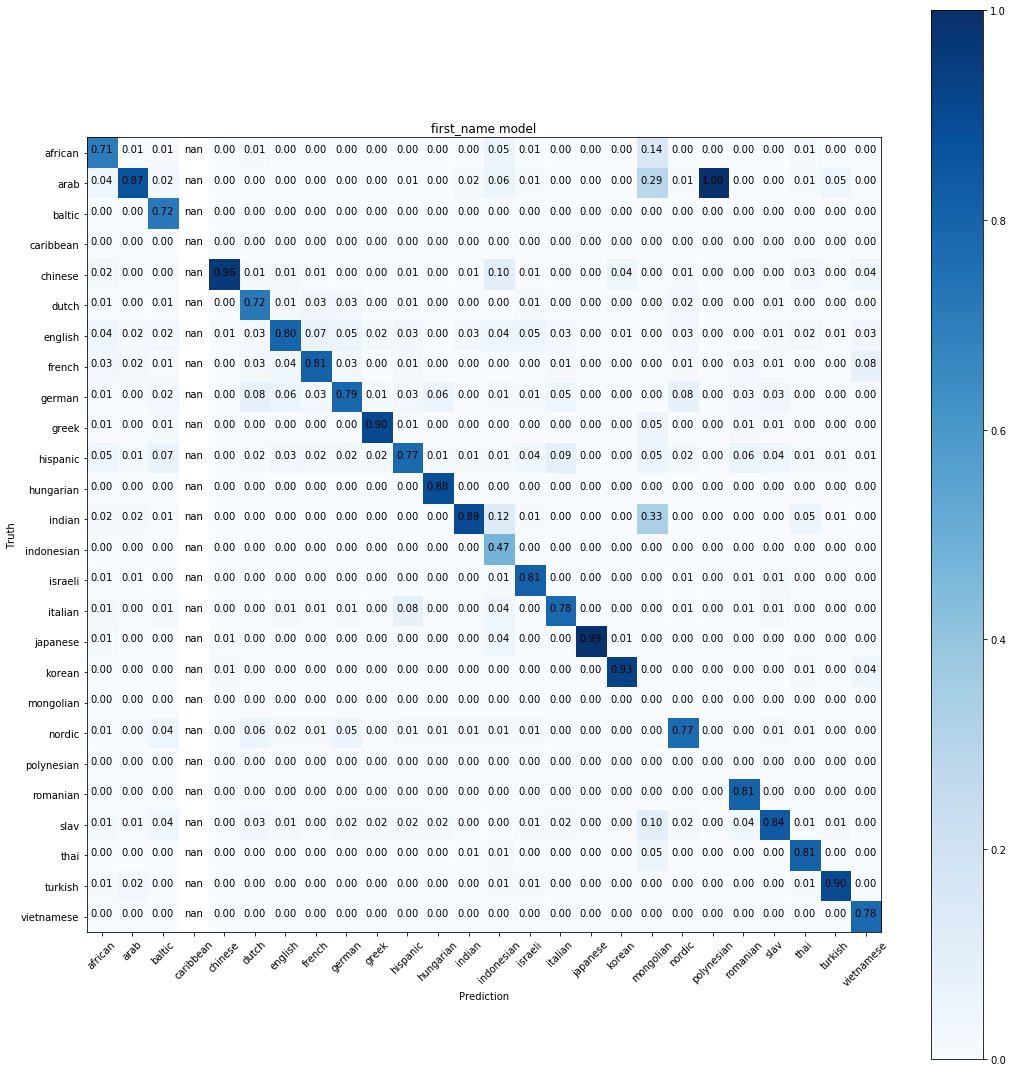

Normalized confusion matrix


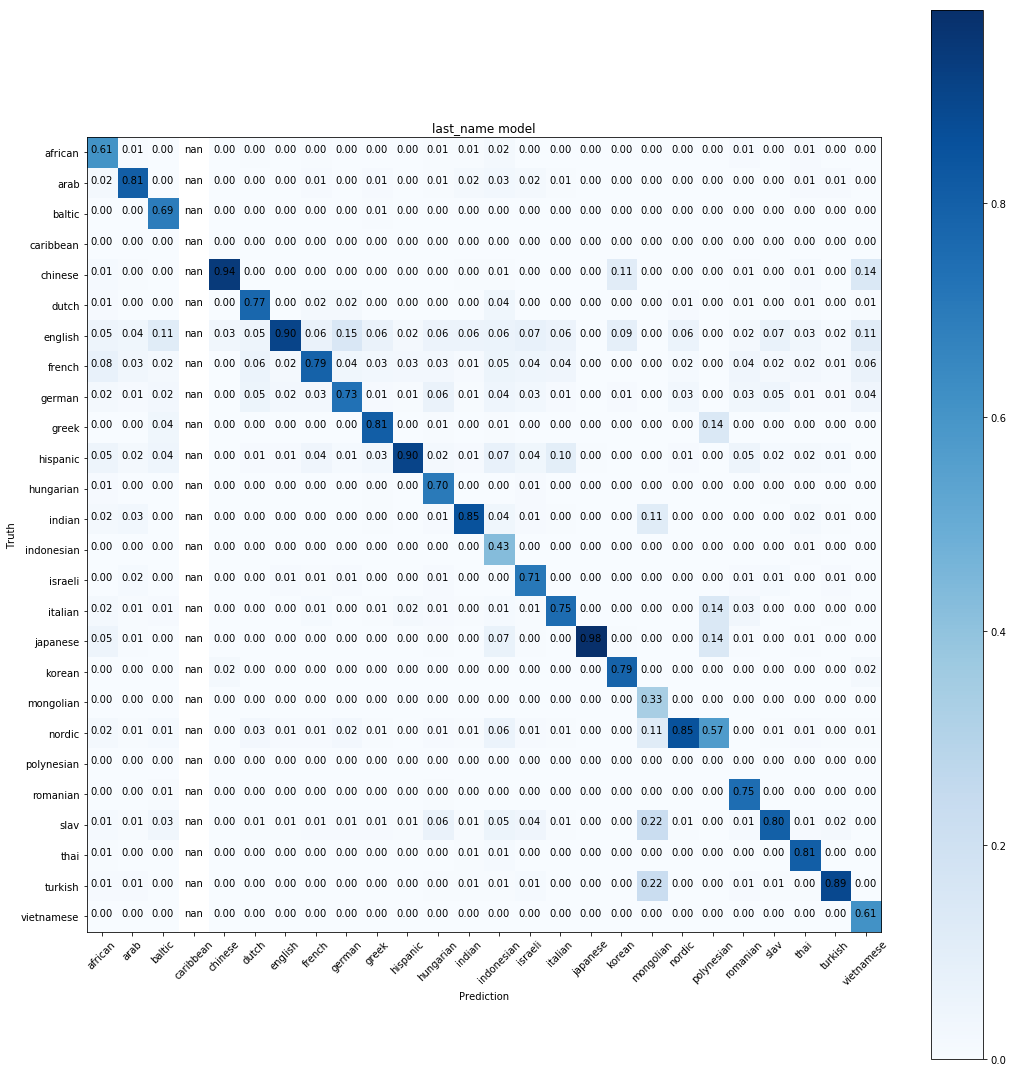

Normalized confusion matrix


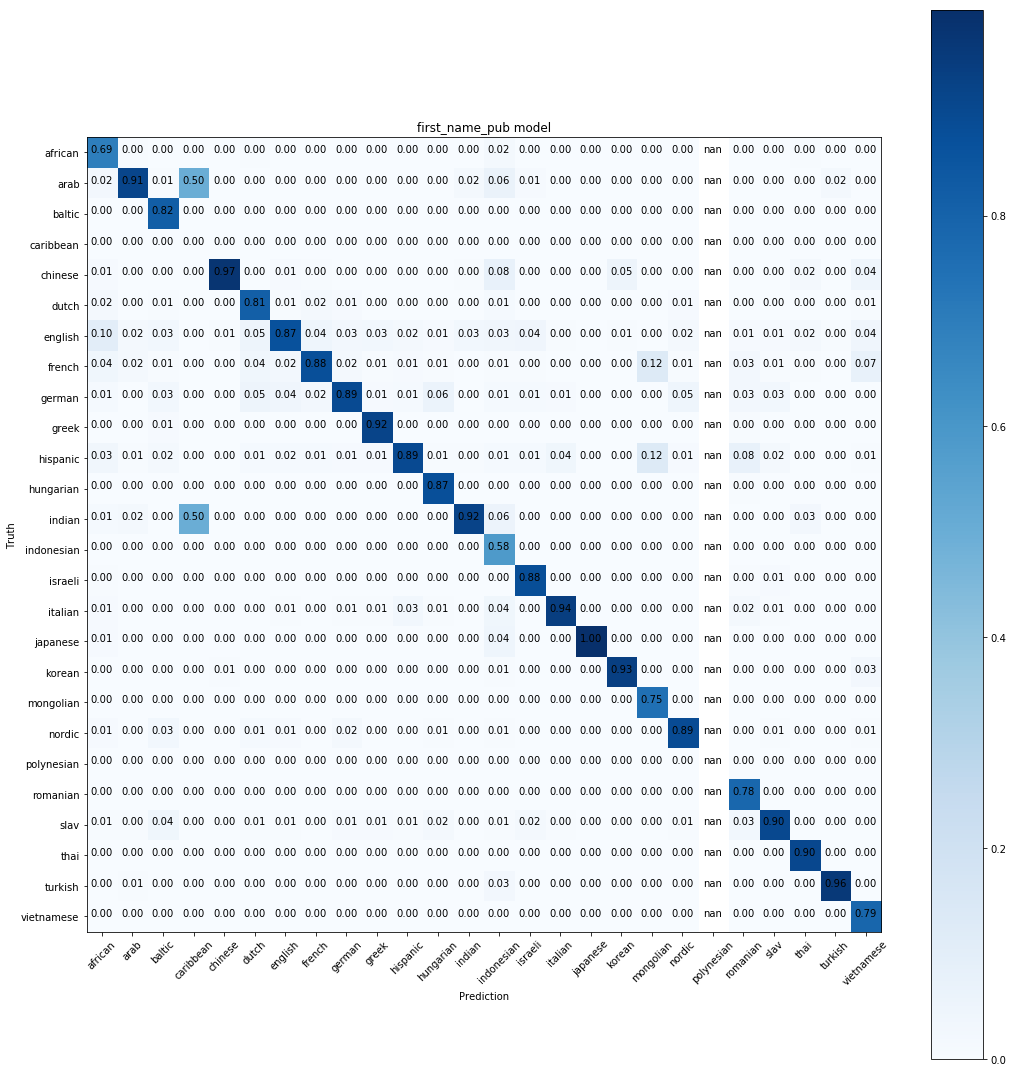

Normalized confusion matrix


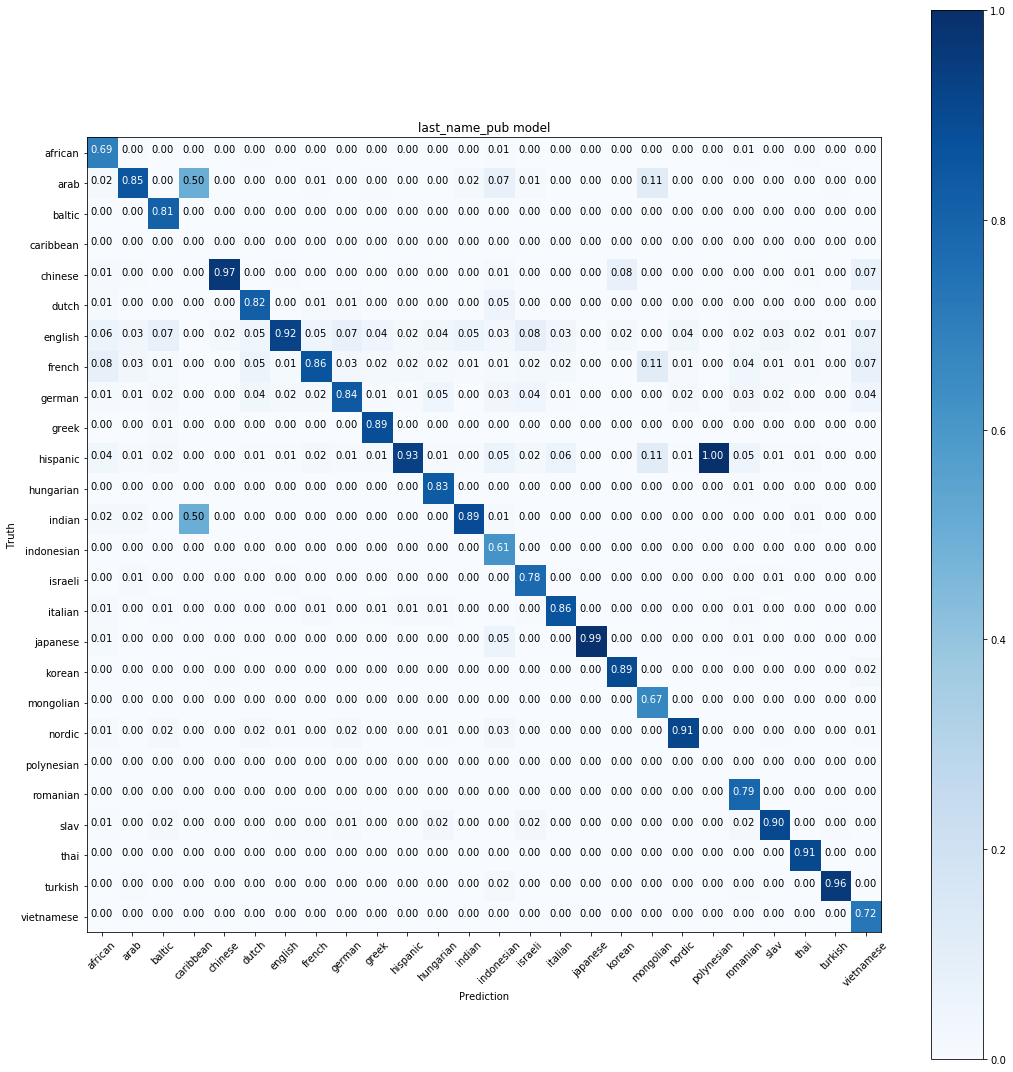

Normalized confusion matrix


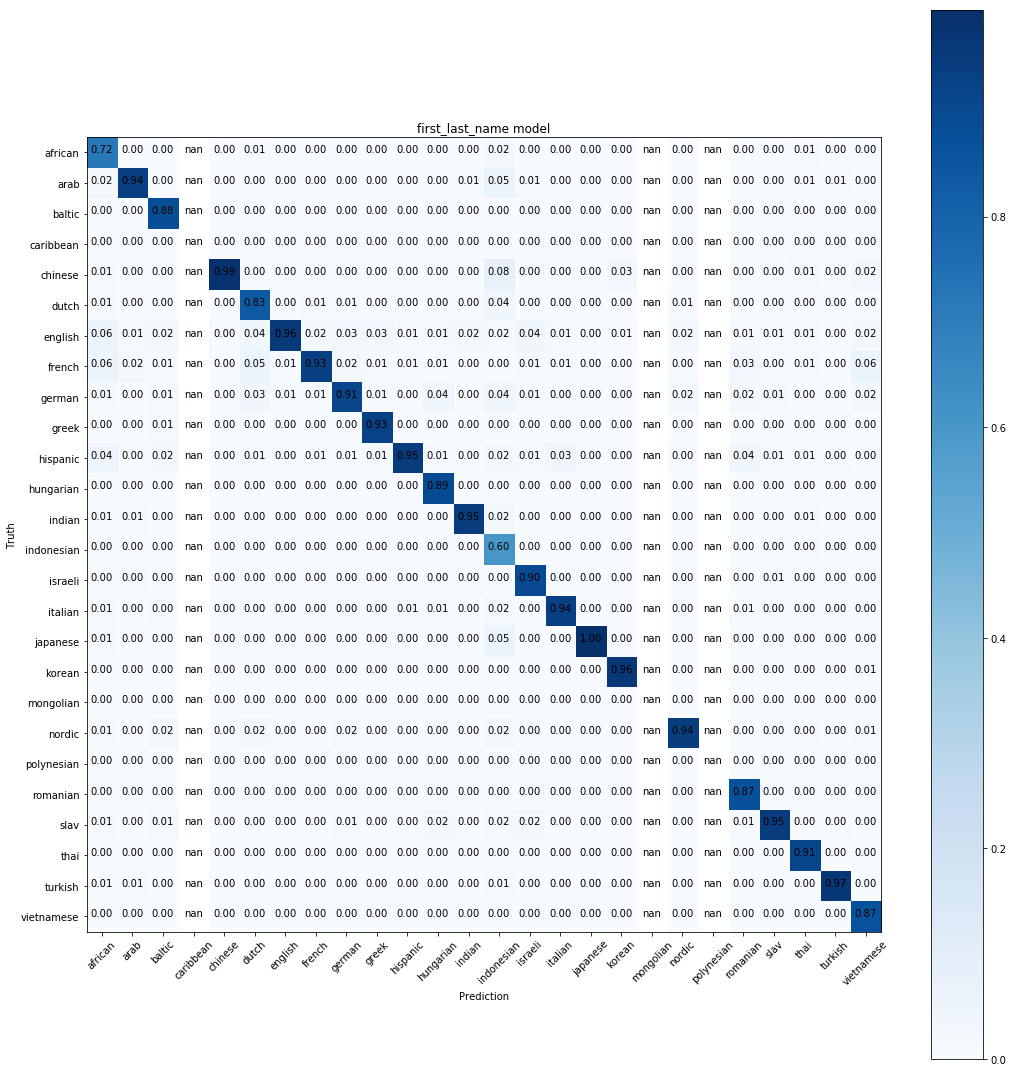

Normalized confusion matrix


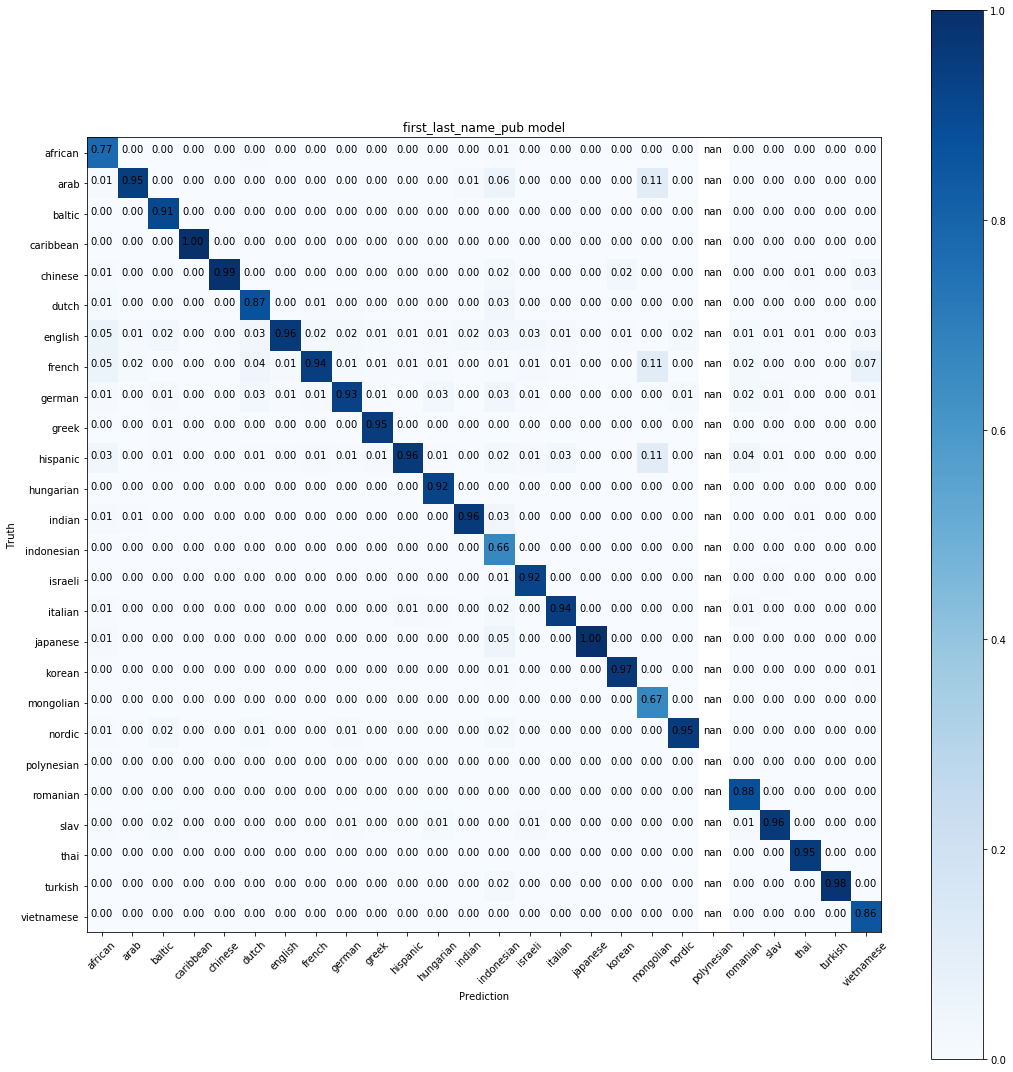

In [102]:
# Compute confusion matrix
for i in range(6):
    cnf_matrix = confusion_matrix(testY,pred_class[i])
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure(figsize=(15,15))
    plot_confusion_matrix(cnf_matrix, classes=ethnic_keys, normalize=True,
                          title="{} model".format(index[i]))

    plt.show()

In [8]:
# embedd the structure vocabulary using text embedding and reduce the dimensionality

# convert the names into word structure vector
struct_dict_keys = list(struct_dict.keys())

def transform_structure(name_struct):
    list_structure = []
    for x in name_struct:
        try:
            list_structure.append(struct_dict_keys.index(x)+1)
        except BaseException:
            list_structure.append(0)
    #add pading 0 for structure less than num_input
    #for i in range(len(list_structure),timesteps):
    #    list_structure.append(0)
    return list_structure   
    #return [*map(lambda x:struct_dict_keys.index(x)+1, name_struct)]

#data_source = full_name_struct.apply(lambda x: transform_structure(x))

In [9]:
def transform_labels(x):
    y = np.zeros(len(ethnic_keys))
    y[ethnic_keys.index(x)]=1
    return y

labels = np.array(list(map(lambda x: transform_labels(x),ethnic_series)))

In [16]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import pickle

with open('train_test_fix.pickle', 'rb') as f:
    trainX,trainY,testX,testY,ethnic_keys,struct_dict_keys = pickle.load(f)
    #aha = pickle.load(f)

#with open('traintest-smote.pickle','rb') as f:
#    train_res,test_res = pickle.load(f)

with open('ethnic_keys.pickle','rb') as f:
    name_struct_keys,ethnic_keys = pickle.load(f)
        
embedding_vector_length = 1000
lstm_layer = 1000
max_sequence = 50

In [ ]:
# convert categorical to binary crossentropy
#trainY = np.array([np.where(x>0)[0][0] for x in trainY])
#testY = np.array([np.where(x>0)[0][0] for x in testY])

#test_res

In [2]:
model = Sequential()
model.add(Embedding(len(name_struct_keys)+1,embedding_vector_length,input_length=max_sequence))
model.add(Conv1D(filters=embedding_vector_length,kernel_size=3,padding='same',activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(LSTM(lstm_layer,dropout=0.8))
model.add(Bidirectional(LSTM(max_sequence*2,return_sequences=False),input_shape=(max_sequence,1)))
#model.add(TimeDistributed(keras.layers.Dense(len(ethnic_keys),activation='softmax')))
model.add(keras.layers.Dense(lten(ethnic_keys),activation='softmax'))
#model.add(keras.layers.Dense(len(ethnic_keys),activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())
for x in range(10):
    model.fit(trainX,trainY,epochs=1,batch_size=1000)
    scores = model.evaluate(testX,testY,verbose=0)
    print("Accuracy: %.2f%%" %(scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 1000)          62696000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 1000)          3001000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               880800    
_________________________________________________________________
dense_1 (Dense)              (None, 23)                4623      
Total params: 66,582,423
Trainable params: 66,582,423
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1
35653/35653 [==============================] - 778s - loss: 1.6879 - acc: 0.5265    
Accuracy: 75.88%
Epoch 1/1
35653/35653 [==============================] - 796s - loss: 0.5197 - acc: 0.8582    
Accuracy: 84.37%
Epoch 1/1
35653/35653 [==========

In [4]:
testX

array([[  112,  1331,  1332, ...,     0,     0,     0],
       [  251,   252,   232, ...,     0,     0,     0],
       [ 4633, 11731, 23123, ...,     0,     0,     0],
       ..., 
       [  696,   697,   698, ...,     0,     0,     0],
       [   25,    26,  5195, ...,     0,     0,     0],
       [ 8671,  8672,  6568, ...,     0,     0,     0]], dtype=int32)

In [44]:
# save this model atlhouth there is something wrong with the features
# I did not lowercase the text :(
#model_json = first_last_name_model.to_json()
#with open('model-keras-w5-bigram-integration-full-lstm-embedding.json','w') as f:
#    f.write(model_json)
#save the last weight
first_name_model.save_weights('model-keras-w5-bigram-first-full-lstm-embedding-3.h5')    

In [91]:
# store the predictions probabilities, predictions and labels
"""
# make a confusion matrix
pred = loaded_model.predict([first_testX,last_testX])
# pred probability distribution

pred_class = np.array([np.argsort(x)[::-1][0] for x in pred])
test_labels = np.array([np.argsort(x)[::-1][0] for x in testY])
predicting_error = test_labels[np.where(pred_class != test_labels)]
class_error = pred_class[np.where(pred_class != test_labels)]

pred_prob = []
predictions = []
"""

def evaluate_probs(firstX, lastX, testY, testIndex, mini_batch_size=20000):
    test_class = []
    pred_class = []    
    pred_prob = []
    
    test_len = len(testY)
    len_mini_batch = round(test_len/mini_batch_size)+1
    print(len_mini_batch)
    for i in range(len_mini_batch):
        print(i)
        y_first_trainX,y_last_trainX,batch_range = generate_batch(firstX,lastX,i,mini_batch_size)
        #pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys), pub_series[testIndex].iloc[batch_range])))        
        pred = model.predict([y_first_trainX,y_last_trainX])
        pred_class_inn =  [np.argsort(x)[::-1][0] for x in pred]
        pred_class.extend(pred_class_inn)
        pred_prob.extend([x[np.argsort(x)[::-1][0]] for x in pred])
    return pred_class,pred_prob
    #scores = model.evaluate([first_testX, last_testX],testY,verbose=0)
    

In [92]:
#pred_class, pred_prob = evaluate_probs(first_testX[0:100],last_testX[0:100], testY[0:100], testIndex)
pred_class, pred_prob = evaluate_probs(first_testX,last_testX, testY, testIndex)

45
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


(array([  2.07000000e+02,   2.28700000e+03,   7.56300000e+03,
          1.39370000e+04,   2.28850000e+04,   2.34090000e+04,
          2.51430000e+04,   3.02170000e+04,   4.46390000e+04,
          7.16530000e+05]),
 array([ 0.14609675,  0.23148708,  0.3168774 ,  0.40226773,  0.48765805,
         0.57304838,  0.6584387 ,  0.74382903,  0.82921935,  0.91460968,  1.        ]),
 <a list of 10 Patch objects>)

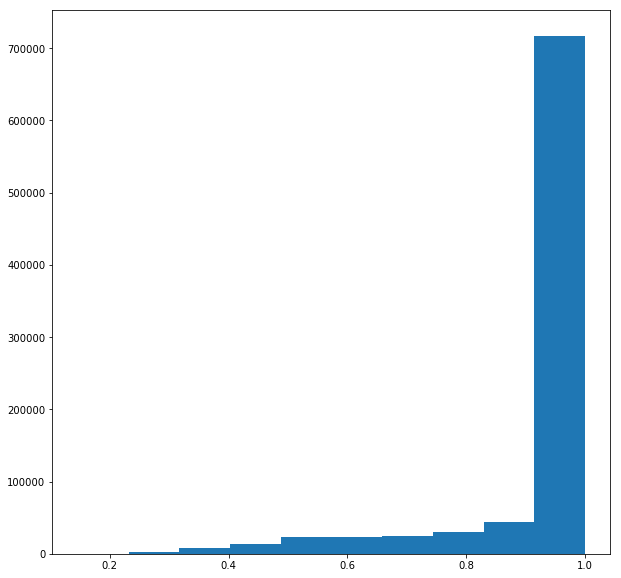

In [95]:
fig,ax = plt.subplots(figsize=(10,10))
ax.hist(pred_prob)

In [102]:
pred_class = np.array(pred_class)
test_labels = np.array([np.argsort(x)[::-1][0] for x in testY])
predicting_error = test_labels[np.where(pred_class != test_labels)]
class_error = pred_class[np.where(pred_class != test_labels)]

Confusion matrix, without normalization


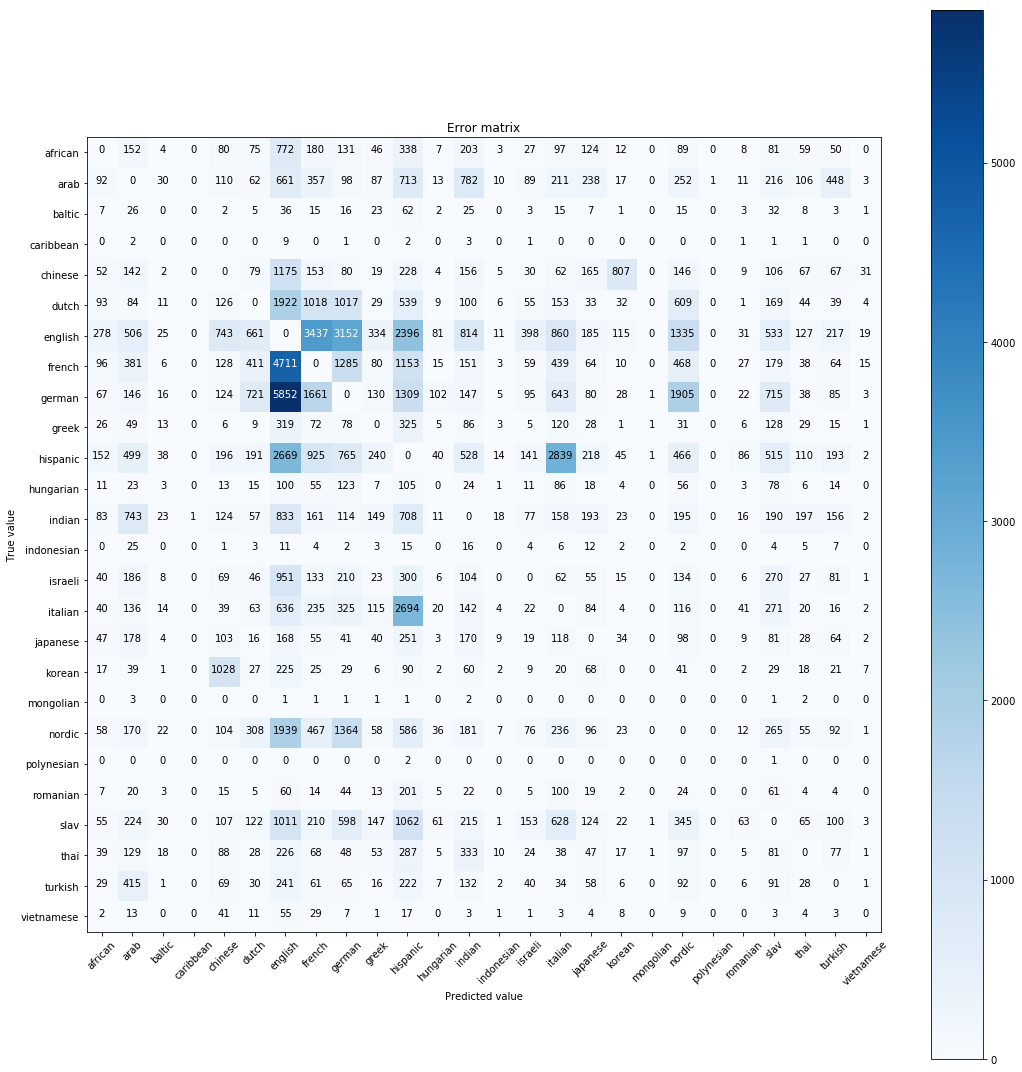

In [103]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True value')
    plt.xlabel('Predicted value')

# Compute confusion matrix
cnf_matrix = confusion_matrix(predicting_error, class_error)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=ethnic_keys,
                      title='Error matrix')

# Plot normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=ethnic_keys, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()

In [111]:
len(struct_dict_keys)

725

In [112]:
struct_dict_keys

['_c',
 'ca',
 'am',
 'me',
 'er',
 'ro',
 'on',
 'n_',
 '_b',
 'be',
 'rt',
 't_',
 '_l',
 'le',
 'ee',
 'en',
 '_e',
 'es',
 'st',
 'th',
 'he',
 'r_',
 'el',
 'll',
 '_p',
 'pe',
 'et',
 'te',
 '_g',
 'ge',
 '_m',
 'ma',
 'ax',
 'x_',
 '_k',
 'kh',
 'ha',
 'al',
 'ed',
 'd_',
 'la',
 'an',
 'ni',
 'ie',
 'e_',
 'eu',
 'un',
 'ic',
 'ce',
 'ch',
 'hr',
 'ri',
 'is',
 'to',
 'op',
 'ph',
 '_j',
 'jo',
 'oo',
 'os',
 '_i',
 'ia',
 'ka',
 'at',
 'hl',
 '_t',
 'rr',
 're',
 'nc',
 'ju',
 'ul',
 'li',
 'iu',
 'us',
 's_',
 '_a',
 'mr',
 'mi',
 'ig',
 'gu',
 'ue',
 'l_',
 '_n',
 'ne',
 'ei',
 'il',
 'je',
 'oe',
 '_h',
 'hy',
 'yu',
 'ah',
 'h_',
 'ar',
 'rk',
 'k_',
 'ab',
 'bd',
 '_s',
 'se',
 'rg',
 'gi',
 'io',
 'o_',
 'uu',
 'dr',
 'pa',
 'au',
 'ja',
 'ik',
 'ke',
 'mu',
 'ir',
 'na',
 '_r',
 'rd',
 'rn',
 'ns',
 'as',
 'sw',
 'wa',
 'nt',
 'ur',
 '_d',
 'de',
 'og',
 'ho',
 'or',
 'ra',
 'ay',
 'ya',
 'a_',
 'em',
 'ad',
 'ak',
 'su',
 'u_',
 '_y',
 'yo',
 'ou',
 'si',
 'if',
 'f_',